# Using FISSA with SIMA

[SIMA](http://www.losonczylab.org/sima/) is a toolbox for motion correction and cell detection.
Here we illustrate how to create a workflow which uses SIMA to detect cells and FISSA to extract decontaminated signals from those cells.

**Reference:**
Kaifosh, P., Zaremba, J. D., Danielson, N. B., Losonczy, A. SIMA: Python software for analysis of dynamic fluorescence imaging data. *Frontiers in neuroinformatics*, **8**(80), 2014. doi:&nbsp;[10.3389/fninf.2014.00080](https://doi.org/10.3389/fninf.2014.00080).

Please note that SIMA only supports Python 3.6 and below.

### Import packages

In [1]:
# FISSA toolbox
import fissa

# SIMA toolbox
import sima
import sima.segment

# File operations
import glob

# For plotting our results, use numpy and matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Detecting cells with SIMA

### Setup data

In [2]:
# Define folder where tiffs are present
tiff_folder = "exampleData/20150529/"

# Find tiffs in folder
tiffs = sorted(glob.glob(tiff_folder + "/*.tif*"))

# define motion correction method
mc_approach = sima.motion.DiscreteFourier2D()

# Define SIMA dataset
sequences = [sima.Sequence.create("TIFF", tiff) for tiff in tiffs[:1]]
try:
    dataset = sima.ImagingDataset(sequences, "example.sima")
except BaseException:
    dataset = sima.ImagingDataset.load("example.sima")

### Run SIMA segmentation algorithm

In [3]:
stica_approach = sima.segment.STICA(components=2)
stica_approach.append(sima.segment.SparseROIsFromMasks())
stica_approach.append(sima.segment.SmoothROIBoundaries())
stica_approach.append(sima.segment.MergeOverlapping(threshold=0.5))
rois = dataset.segment(stica_approach, "auto_ROIs")

/opt/hostedtoolcache/Python/3.6.15/x64/lib/python3.6/site-packages/sima/ROI.py:242: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in self.polygons:
/opt/hostedtoolcache/Python/3.6.15/x64/lib/python3.6/site-packages/sima/ROI.py:655: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(polygons) == 0:
/opt/hostedtoolcache/Python/3.6.15/x64/lib/python3.6/site-packages/sima/ROI.py:660: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  elif isinstance(polygons[0], Polygon):
/opt/hostedtoolcache/Python/3.6.15/x64/li

### Plot detected cells

/opt/hostedtoolcache/Python/3.6.15/x64/lib/python3.6/site-packages/sima/ROI.py:242: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in self.polygons:
/opt/hostedtoolcache/Python/3.6.15/x64/lib/python3.6/site-packages/sima/ROI.py:242: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in self.polygons:
/opt/hostedtoolcache/Python/3.6.15/x64/lib/python3.6/site-packages/sima/ROI.py:242: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in self.polygons:


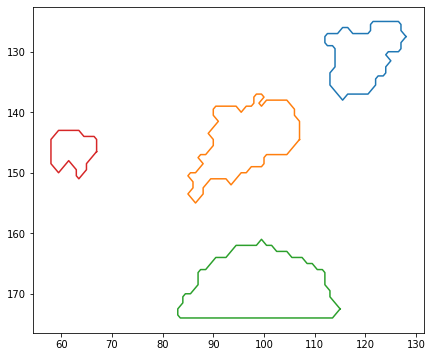

In [4]:
# Plotting lines surrounding each of the ROIs
plt.figure(figsize=(7, 6))

for roi in rois:
    # Plot border around cell
    plt.plot(roi.coords[0][:, 0], roi.coords[0][:, 1])

# Invert the y-axis because image co-ordinates are labelled from top-left
plt.gca().invert_yaxis()
plt.show()

## Extract decontaminated signals with FISSA

FISSA needs either ImageJ ROIs or numpy arrays as inputs for the ROIs. 

SIMA outputs ROIs as numpy arrays, and can be directly read into FISSA.

A given roi is given as
```python
rois[i].coords[0][:, :2]
```

FISSA expects rois to be provided as a list of lists
```python
[[roiA1, roiA2, roiA3, ...]]
```
So some formatting will need to be done first.

In [5]:
rois_fissa = [roi.coords[0][:, :2] for roi in rois]

/opt/hostedtoolcache/Python/3.6.15/x64/lib/python3.6/site-packages/sima/ROI.py:242: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in self.polygons:


In [6]:
rois[0].coords[0][:, :2].shape

(37, 2)

We can then run FISSA on the data using the ROIs supplied by SIMA having converted them to a FISSA-compatible format, `rois_fissa`.

In [7]:
output_folder = "fissa_sima_example"
experiment = fissa.Experiment(tiff_folder, [rois_fissa], output_folder)
experiment.separate()

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 0.526 seconds.
Saving extracted traces to fissa_sima_example/prepared.npz


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 1.207 seconds
Saving results to fissa_sima_example/separated.npz


### Plotting the results

In [8]:
# Fetch the colormap object for Cynthia Brewer's Paired color scheme
cmap = plt.get_cmap("Paired")

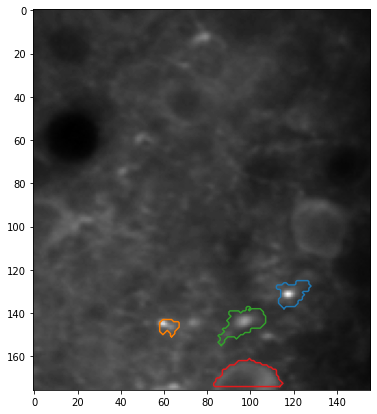

In [9]:
# Select which trial (TIFF index) to plot
trial = 0

# Plot the mean image and ROIs from the FISSA experiment
plt.figure(figsize=(7, 7))
plt.imshow(experiment.means[trial], cmap="gray")

for i_roi in range(len(experiment.roi_polys)):
    # Plot border around ROI
    for contour in experiment.roi_polys[i_roi, trial][0]:
        plt.plot(
            contour[:, 1],
            contour[:, 0],
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )

plt.show()

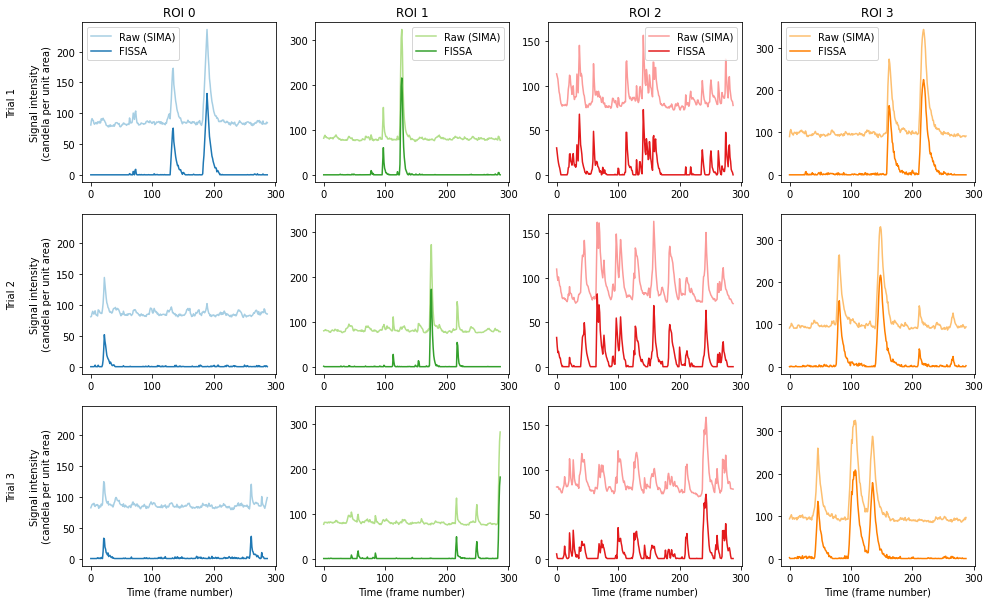

In [10]:
# Plot all ROIs and trials

# Get the number of ROIs and trials
n_roi = experiment.result.shape[0]
n_trial = experiment.result.shape[1]

# Find the maximum signal intensities for each ROI
roi_max_raw = [
    np.max([np.max(experiment.raw[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]
roi_max_result = [
    np.max([np.max(experiment.result[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]
roi_max = np.maximum(roi_max_raw, roi_max_result)

# Plot our figure using subplot panels
plt.figure(figsize=(16, 10))
for i_roi in range(n_roi):
    for i_trial in range(n_trial):
        # Make subplot axes
        i_subplot = 1 + i_trial * n_roi + i_roi
        plt.subplot(n_trial, n_roi, i_subplot)
        # Plot the data
        plt.plot(
            experiment.raw[i_roi][i_trial][0, :],
            label="Raw (SIMA)",
            color=cmap((i_roi * 2) % cmap.N),
        )
        plt.plot(
            experiment.result[i_roi][i_trial][0, :],
            label="FISSA",
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )
        # Labels and boiler plate
        plt.ylim([-0.05 * roi_max[i_roi], roi_max[i_roi] * 1.05])
        if i_roi == 0:
            plt.ylabel(
                "Trial {}\n\nSignal intensity\n(candela per unit area)".format(
                    i_trial + 1
                )
            )
        if i_trial == 0:
            plt.legend()
            plt.title("ROI {}".format(i_roi))
        if i_trial == n_trial - 1:
            plt.xlabel("Time (frame number)")

plt.show()

The figure shows the raw signal from the ROI identified by SIMA (pale), and after decontaminating with FISSA (dark).
The hues match the ROI locations drawn above.
Each column shows the results from one of the ROIs detected by SIMA.
Each row shows the results from one of the three trials.